<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DBSCAN Practice

---

You're now familiar with how DBSCAN works. Let's practice it in sklearn.

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric

from sklearn import cluster
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist, squareform

from sklearn import datasets
from math import radians, cos, sin, asin, sqrt

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## UK postcodes

Now we will do clustering on UK postcodes based on their coordinates. Adjust the parameters of DBSCAN - different values will allow you to see different structures. What would you expect to see?

### 1. Read in the following CSV file containing the outgoing UK postcodes together with their coordinates of longitude and latitude

In [2]:
X = pd.read_csv(
    'https://www.freemaptools.com/download/outcode-postcodes/postcode-outcodes.csv')

In [3]:
X.drop(X.index[(X.latitude == 0) ], inplace=True)

### 2. Load the following function. It calculates the distance between any points on the Earth's surface specified by their longitude and latitude in degrees.

In [4]:
def haversine(lonlat1, lonlat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = list(map(radians, [lon1, lat1, lon2, lat2]))

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2.)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2.)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [5]:
X.shape

(2975, 4)

### 3. Calculate the distance matrix between each pair of points

In [6]:
my_metric = pdist(X.loc[:, ['latitude', 'longitude']],
                  (lambda u, v: haversine(u, v)))

In [7]:
my_metric.shape

(4423825,)

In [8]:
distance_matrix = squareform(my_metric)

In [9]:
X.head()

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089
2,4,AB12,57.10100,-2.11060
3,5,AB13,57.10801,-2.23776
4,6,AB14,57.10076,-2.27073


In [10]:
print(distance_matrix.shape)

(2975, 2975)


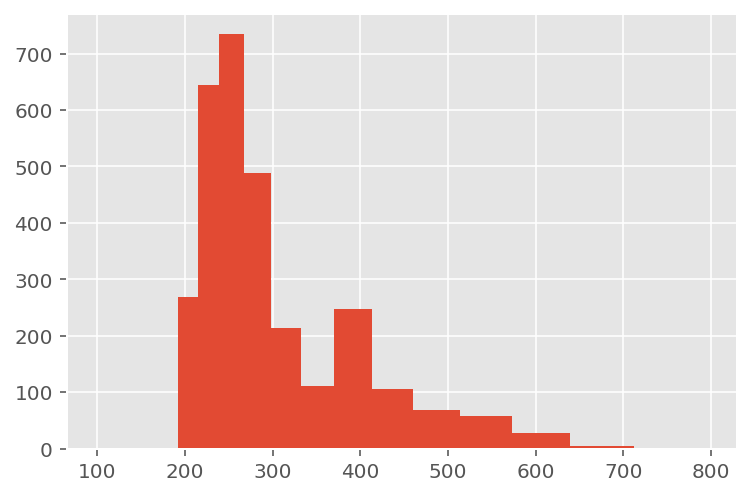

In [11]:
# distribution of mean distances from any given point
plt.hist(distance_matrix.mean(axis=1), bins=np.logspace(2, 2.9, 20))
plt.show()

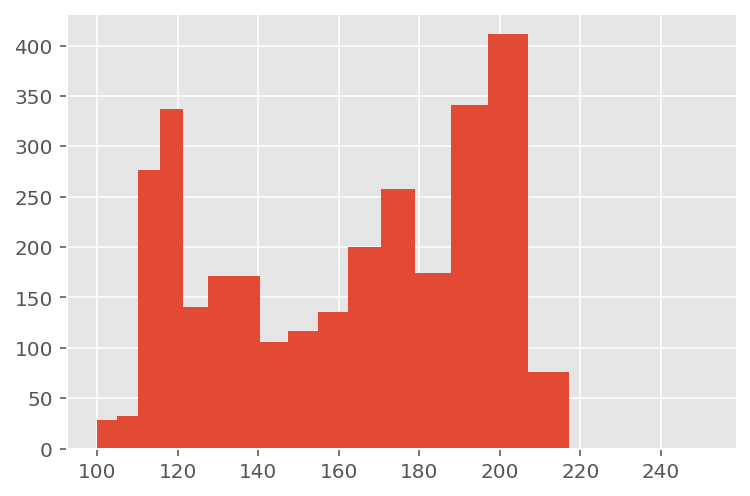

In [12]:
plt.hist(distance_matrix.std(axis=1), bins=np.logspace(2, 2.4, 20))
plt.show()

### 4. Do DBSCAN clustering on the distance matrix with the precomputed metric. Adjust the values of eps and min_samples to obtain a suitable number of clusters

In [13]:
db = DBSCAN(eps=10, min_samples=20, metric='precomputed')
y_db = db.fit_predict(distance_matrix)  # do your fit on the distance matrix

In [14]:
X['cluster'] = y_db

In [15]:
X.head()

,id,postcode,latitude,longitude,cluster
0,2,AB10,57.13514,-2.11731,-1
1,3,AB11,57.13875,-2.09089,-1
2,4,AB12,57.10100,-2.11060,-1
3,5,AB13,57.10801,-2.23776,-1
4,6,AB14,57.10076,-2.27073,-1


In [16]:
X['cluster'] = X.cluster

In [17]:
print(len(X.cluster.unique()))
X.cluster.value_counts()

13


-1     1983
 4      379
 0      103
 3       89
 7       83
 1       77
 10      64
 8       59
 11      35
 9       34
 5       28
 2       21
 6       20
Name: cluster, dtype: int64

In [18]:
X_postcode = X.copy()

### 5. Produce a scatter plot of the angular variables with points coloured according to their cluster label

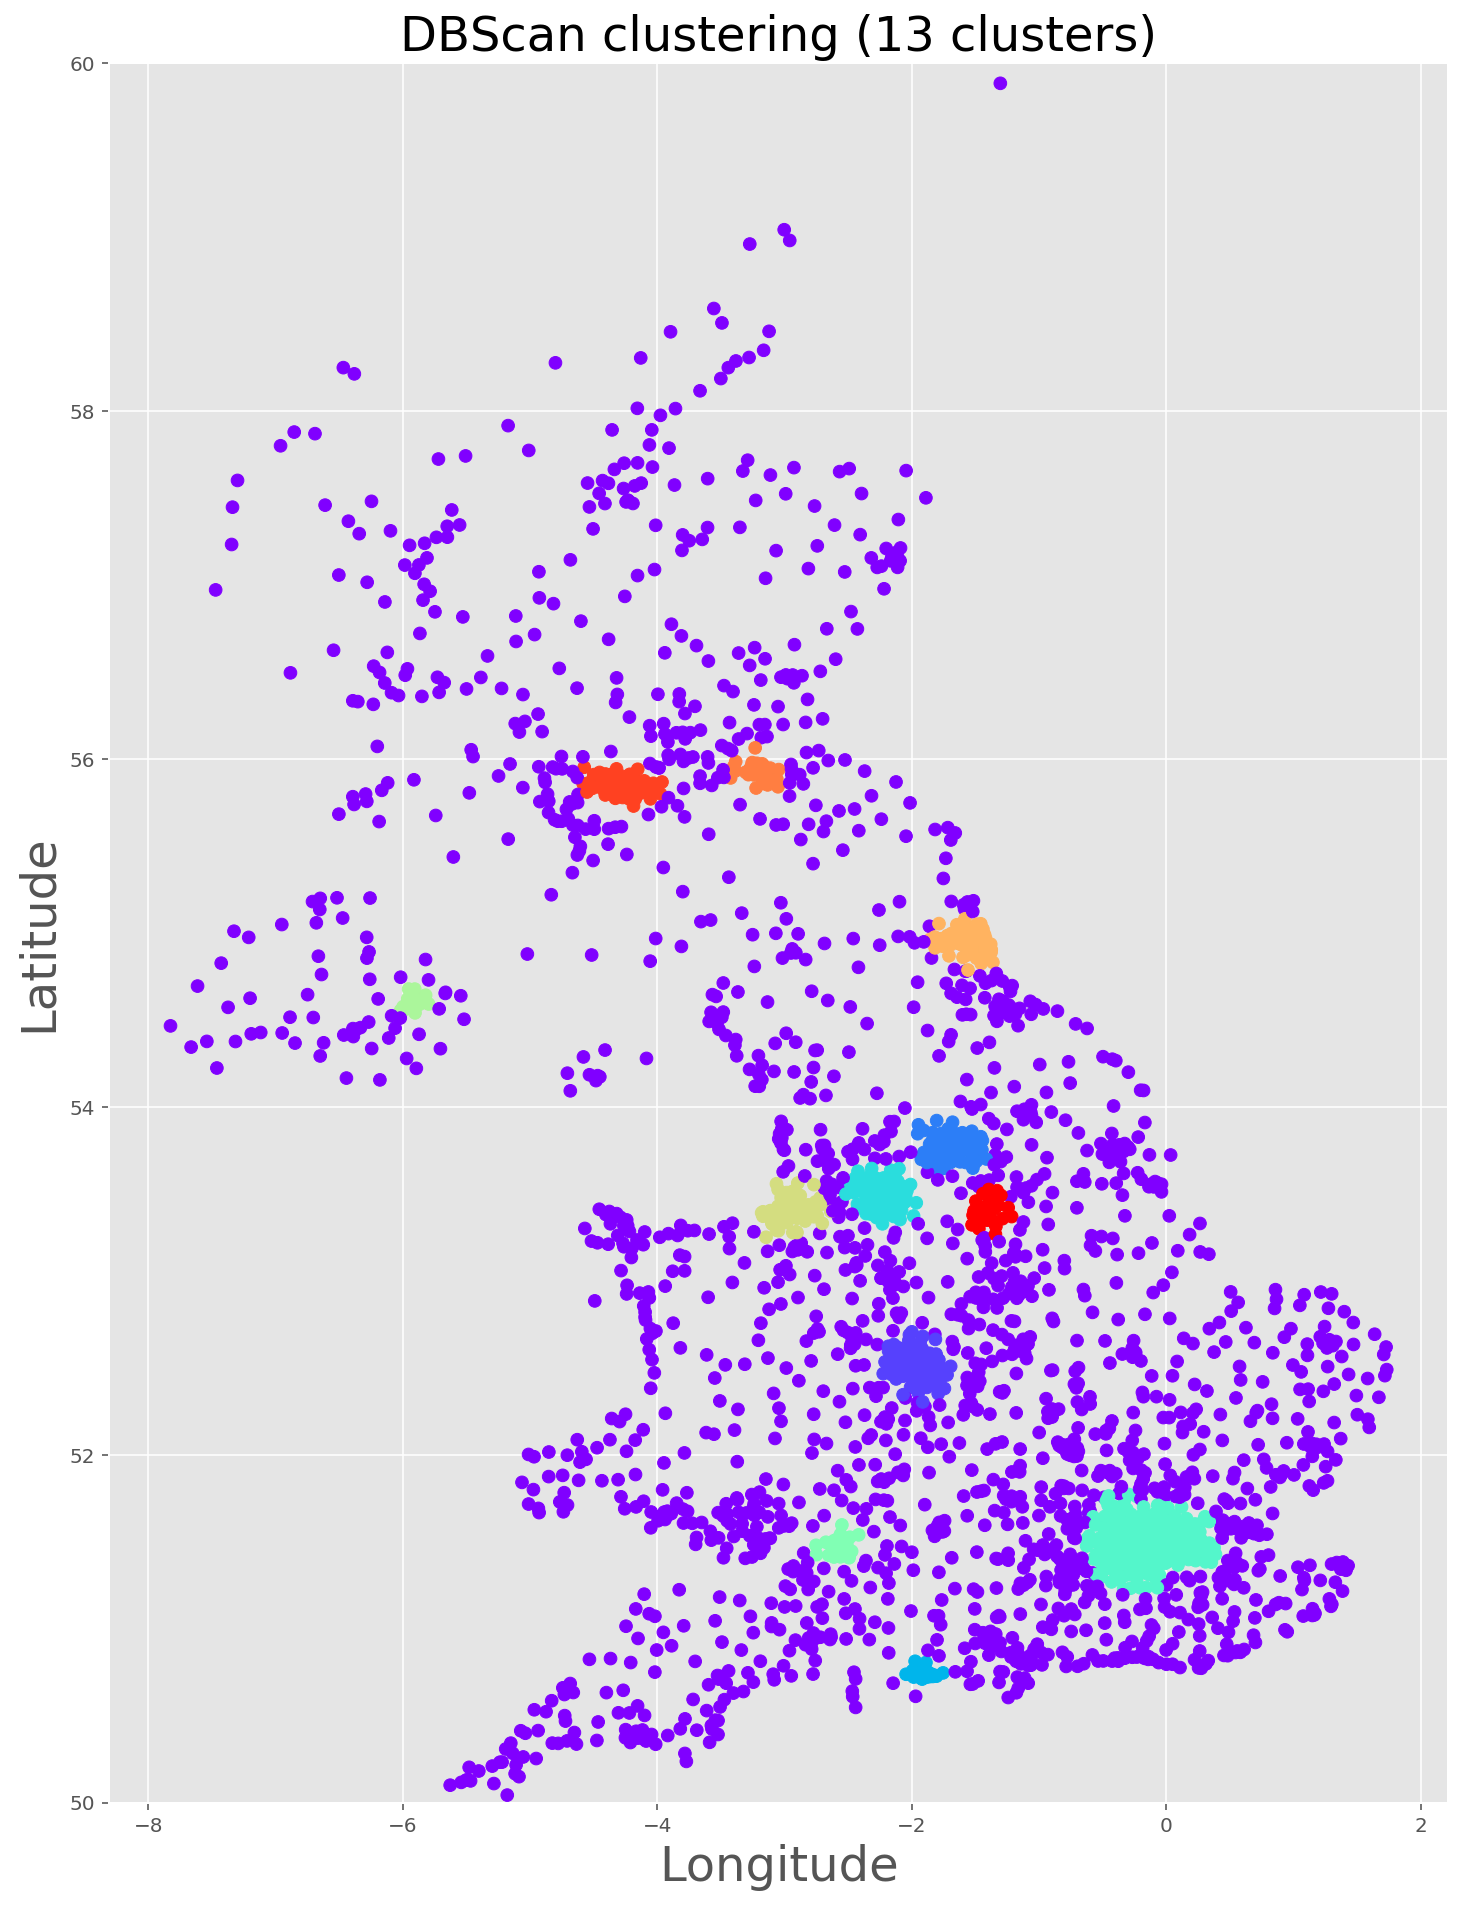

In [19]:
from matplotlib import cm
plt.figure(figsize=(12, 16))
plt.scatter(X['longitude'], X['latitude'], c=X['cluster'],
            cmap=cm.get_cmap('rainbow'), s=40)
plt.ylim([50, 60])
plt.xlabel('Longitude', fontsize=24)
plt.ylabel('Latitude', fontsize=24)
plt.title('DBScan clustering (13 clusters)', fontsize=24)
plt.show()

## Bonus:

### Try k-means and hierarchical clustering on the given datasets. Which differences do you observe? Which algorithm do you find most suitable in each case?

In [20]:
from sklearn.cluster import KMeans, AgglomerativeClustering

### K-means and hierarchical clustering on the postcode dataset

In [21]:
k = 14
kmeans = KMeans(n_clusters=k)
# works only with Euclidean distances
# calculate based on differences in latitude and longitude coordinate
# this i not very accurate for distance between points 
kmeans.fit(X[['latitude', 'longitude']]) 

labels = kmeans.labels_

In [22]:
X_postcode['cluster_kmeans'] = labels
X_postcode.cluster_kmeans.value_counts()

4     646
7     325
13    284
2     282
5     268
11    202
12    182
0     166
8     151
9     114
1      94
3      89
6      89
10     83
Name: cluster_kmeans, dtype: int64

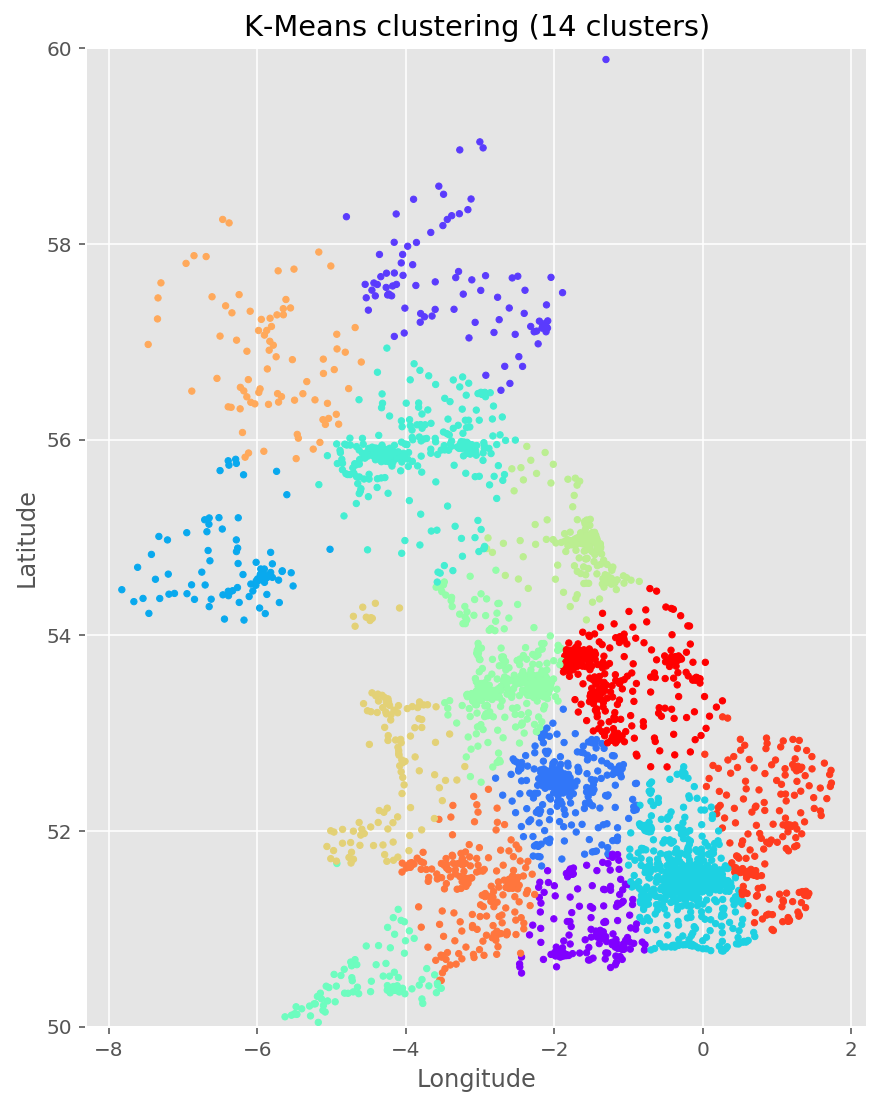

In [23]:
plt.figure(figsize=(7, 9))
plt.scatter(X_postcode['longitude'], X_postcode['latitude'],
            c=X_postcode['cluster_kmeans'],
            cmap=cm.get_cmap('rainbow'), s=10)
plt.ylim([50, 60])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means clustering (14 clusters)')
plt.show()

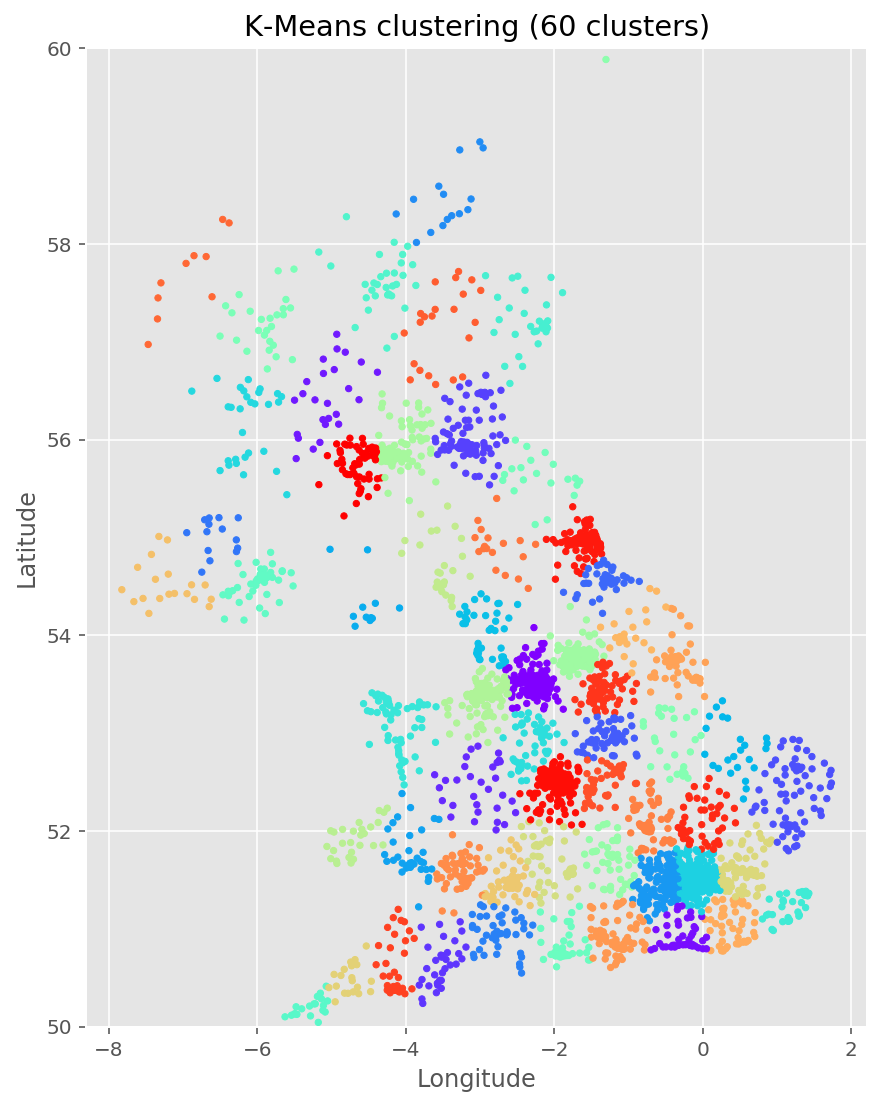

In [24]:
k = 60
kmeans = KMeans(n_clusters=k)
kmeans.fit(X[['latitude', 'longitude']])
labels = kmeans.labels_
X_postcode['cluster_kmeans'] = labels
plt.figure(figsize=(7, 9))
plt.scatter(X_postcode['longitude'], X_postcode['latitude'],
            c=X_postcode['cluster_kmeans'],
            cmap=cm.get_cmap('rainbow'), s=10)
plt.ylim([50, 60])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means clustering (60 clusters)')
plt.show()

In [25]:
agg = cluster.AgglomerativeClustering(n_clusters=14,
                                      affinity='precomputed', 
                                      linkage='average')
cluster_hiersk = agg.fit_predict(distance_matrix)
X_postcode['cluster_hiersk'] = cluster_hiersk
print(X_postcode.cluster_hiersk.value_counts())

2     897
4     819
5     305
12    264
3     203
0     120
1      90
10     88
9      80
7      79
8      13
6       9
13      5
11      3
Name: cluster_hiersk, dtype: int64


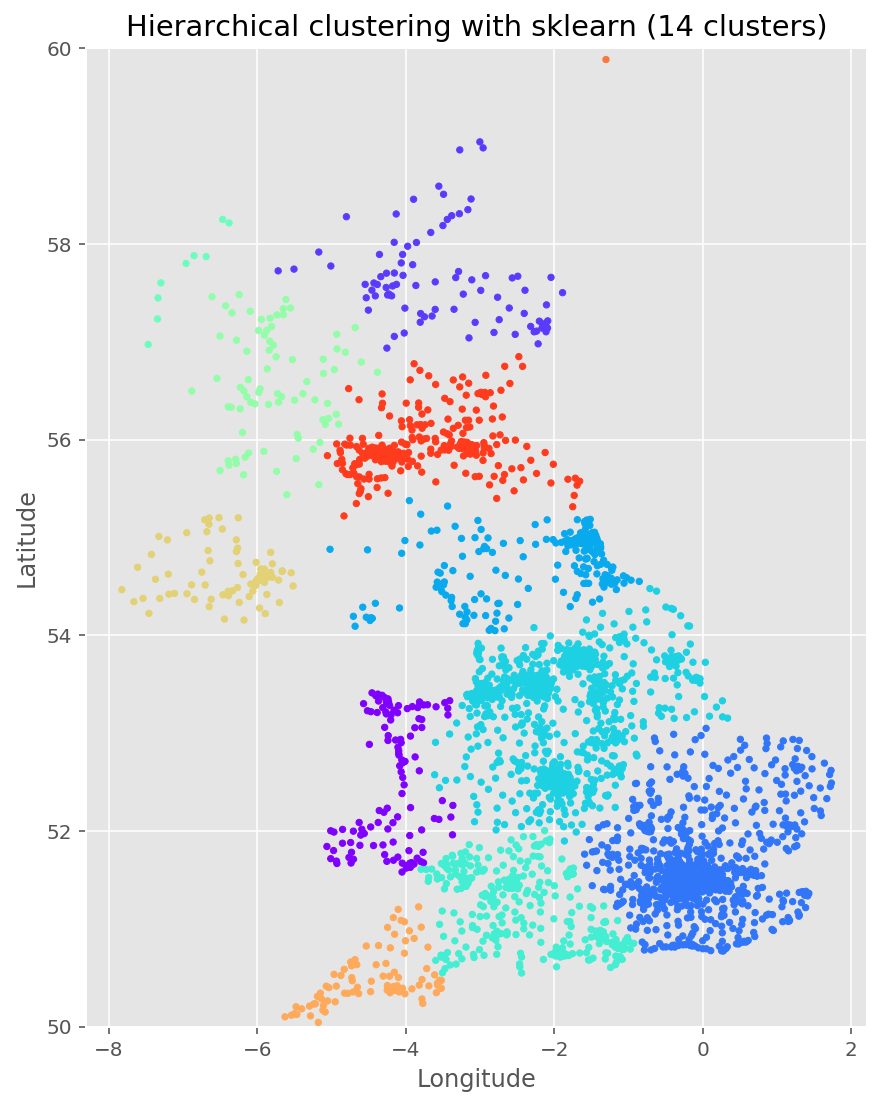

In [26]:
plt.figure(figsize=(7, 9))
plt.scatter(X_postcode['longitude'], X_postcode['latitude'],
            c=cluster_hiersk,
            cmap=cm.get_cmap('rainbow'), s=10)
plt.ylim([50, 60])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hierarchical clustering with sklearn (14 clusters)')
plt.show()

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

In [28]:
np.allclose(distance_matrix[np.triu_indices(
    distance_matrix.shape[1], k=1)], my_metric)

True

In [29]:
my_metric.shape

(4423825,)

In [30]:
# scipy needs flattened upper triangular part of the distance matrix
Z = linkage(my_metric, 'average')
c, coph_dists = cophenet(Z, my_metric)

print(c)
print(len(coph_dists))
print(coph_dists.mean())

0.799523463274868
4423825
289.09134458583685


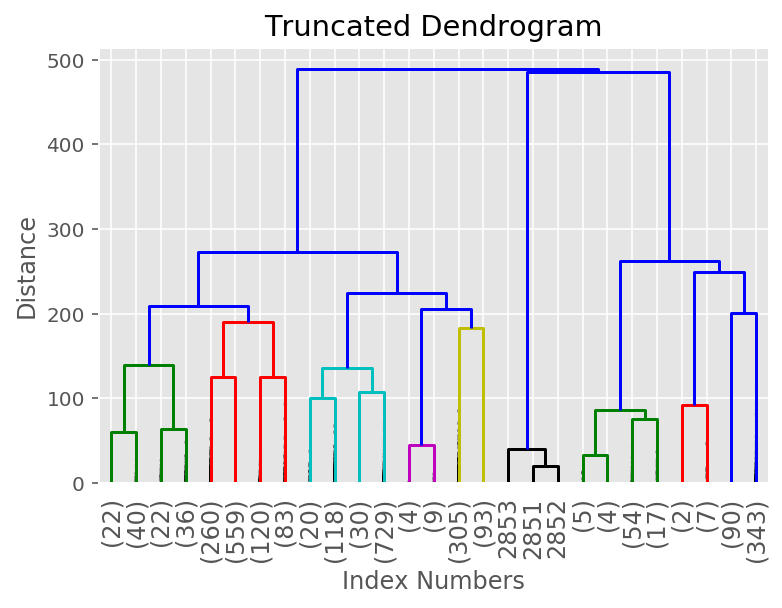

In [31]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='level',
    p=4,
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    color_threshold=200
)
plt.show()

In [32]:
clusters = fcluster(Z, 14, criterion='maxclust')
print(len(set(clusters)))

14
